In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import cm as CM

import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
import tensorflow as tf

project_root = '..'
sys.path.append(project_root)

from sleeprnn.nn.spectrum import compute_wavelets, apply_wavelets_rectangular
from sleeprnn.helpers import reader, plotter, printer, misc, performer
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
viz.notebook_full_width()

### General settings

In [2]:
general_lw = 1.0
signal_lw = 0.8
dpi = viz.DPI
general_color = viz.GREY_COLORS[9]
signal_color = viz.GREY_COLORS[7]
custom_color = viz.PALETTE['blue'] # viz.PALETTE['cyan'] # viz.PALETTE['blue']
ss_color = viz.PALETTE['blue']
kc_color = viz.PALETTE['green']
pred_color = viz.PALETTE['red']

### SS and KC example

In [ ]:
subject_id = 1
which_kc_stamp = 195
left_context = 4
right_context = 6
y_max = 140
y_min = -140
figsize = (4, 2)
alpha = 1
linewidth_mark = 3
ss_correction_right = -0.1

dataset = reader.load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

segment_size = left_context + right_context
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)

segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
segment_signal = signal[start_sample:end_sample]
time_axis = np.arange(start_sample, end_sample) / fs

fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=figsize)

ax.plot(time_axis, segment_signal, linewidth=0.6, color=signal_color)
stamp_label_used = False
for stamp in segment_stamps_ss:
    if stamp_label_used:
        label = None
    else:
        label = 'Sleep Spindle'
        stamp_label_used = True
    ax.plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [y_min, y_min], label=label, 
        color=ss_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=ss_color, alpha=alpha, label=label)
stamp_label_used = False
for stamp in segment_stamps_kc:
    if stamp_label_used:
        label = None
    else:
        label = 'K-Complex'
        stamp_label_used = True
    ax.plot(
        stamp / fs, [y_min, y_min], label=label, 
        color=kc_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=kc_color, alpha=alpha, label=label)
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
ax.set_yticks([-50, 0, 50])
ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
ax.set_ylim([y_min, y_max])
ax.set_xticks([])
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
ax.grid(b=True, axis='x', which='minor')
lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both',length=0)
for lh in lg.legendHandles:
    lh.set_alpha(min(2 * alpha, 1.0))

# Change color of plot
plt.setp(lg.get_texts(), color=general_color)
ax = plotter.set_axis_color(ax, general_color)
plt.tight_layout()

# plt.savefig("ss_kc_example.eps")

plt.show()

### CWT

In [ ]:
subject_id = 1
which_kc_stamp = 195
left_context = 4
right_context = 6
y_max = 140
y_min = -140
figsize = (4, 2)
alpha = 1
linewidth_mark = 3
ss_correction_right = -0.1
n_scales = 32

dataset = reader.load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

segment_size = left_context + right_context
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)

segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
segment_signal = signal[start_sample:end_sample]
time_axis = np.arange(start_sample, end_sample) / fs

# Build computational for CWT

border_size = int(5 * fs)
segment_signal_cwt = signal[start_sample - border_size:end_sample + border_size]
tf.reset_default_graph()
inputs = tf.placeholder(
    dtype=tf.float32, shape=[None, segment_signal_cwt.size], name="feats_train_ph")
wavelets, frequencies = compute_wavelets(
    fb_list=[0.5],
    fs=fs,
    lower_freq=0.5,
    upper_freq=30,
    n_scales=n_scales,
    size_factor=1.0,
    flattening=False,
    trainable=False,
    name='cmorlet')
outputs = apply_wavelets_rectangular(
    inputs=inputs,
    wavelets=wavelets,
    border_crop=border_size,
    stride=1,
    name='cwt')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
results, kernels = sess.run([outputs, wavelets], feed_dict={inputs: [segment_signal_cwt]})
results_real = results[0, ..., 0]
results_imag = results[0, ..., 1]
kernels_real = np.squeeze(kernels[0][0])
kernels_imag = np.squeeze(kernels[0][1])
cwt_magnitude = np.sqrt(results_real ** 2 + results_imag ** 2).T

# FREQ RESPONSE
kernel_size_display = int(2 * fs) + 1
wavelet_to_show_idx = n_scales // 2
wavelet_to_show_real = kernels_real[:, wavelet_to_show_idx]
wavelet_to_show_imag = kernels_imag[:, wavelet_to_show_idx]
ntaps = wavelet_to_show_real.size
max_freq = 50
min_freq = 0.1
compensation_factor_list = []
freq_axis_list = []
fft_kernel_list = []
for i in range(n_scales):
    this_kernel = kernels_real[:, i]
    max_kernel_size_to_fft = ntaps + 2000
    kernel_base = np.zeros(max_kernel_size_to_fft)
    half_sample = kernel_base.size // 2
    kernel_full = kernel_base.copy()
    kernel_half_size = this_kernel.size // 2
    start_kernel = half_sample - kernel_half_size
    end_kernel = half_sample + kernel_half_size + 1
    kernel_full[start_kernel:end_kernel] = this_kernel
    fft_kernel, freq_axis = utils.power_spectrum(kernel_full, fs)
    compensation_factor = 1 / fft_kernel.max()
    compensation_factor_list.append(compensation_factor)
    
results_real_compensated = results_real * np.reshape(compensation_factor_list, [1, n_scales])
results_imag_compensated = results_imag * np.reshape(compensation_factor_list, [1, n_scales])
cwt_magnitude_compensated = np.sqrt(results_real_compensated ** 2 + results_imag_compensated ** 2).T
print('Done')

In [ ]:
fig, axes = plt.subplots(2, 1, dpi=dpi, figsize=(4, 4))

ax = axes[0]
ax.plot(time_axis, segment_signal, linewidth=0.6, color=signal_color)
stamp_label_used = False
for stamp in segment_stamps_ss:
    if stamp_label_used:
        label = None
    else:
        label = 'Sleep Spindle'
        stamp_label_used = True
    ax.plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [y_min+5, y_min+5], label=label, 
        color=ss_color, linewidth=linewidth_mark)
stamp_label_used = False
for stamp in segment_stamps_kc:
    if stamp_label_used:
        label = None
    else:
        label = 'K-Complex'
        stamp_label_used = True
    ax.plot(
        stamp / fs, [y_min+5, y_min+5], label=label, 
        color=kc_color, linewidth=linewidth_mark)
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
ax.set_yticks([-50, 0, 50])
ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
ax.set_ylim([y_min, y_max])
ax.set_xticks([])
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
ax.grid(b=True, axis='x', which='minor')
lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both',length=0)
plt.setp(lg.get_texts(), color=general_color)
ax = plotter.set_axis_color(ax, general_color)

ax = axes[1]
# CWT
ax = axes[1]
ax.set_title('Continuous Wavelet Transform (CWT)', fontsize=viz.FONTSIZE_GENERAL, loc='left')
ax.imshow(
    cwt_magnitude_compensated, interpolation='none',
    extent=[time_axis[0], time_axis[-1], 0, 1], aspect='auto')
ax.set_xticks([])
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
freq_pos = np.linspace(0, 1, n_scales)
freq_val = frequencies[::-1]
val_to_show = [0.5, 4, 8, 13, 30]
idx_useful = [misc.closest_index(single_val, freq_val) for single_val in val_to_show]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]
ax.set_yticks(chosen_freq_pos)
ax.set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax = plotter.set_axis_color(ax, general_color)

plt.tight_layout()

# Mother wavelet inset
axins = inset_axes(ax, width="30%", height="30%", loc=4, borderpad=0.5)
axins.plot(wavelet_to_show_real[500:-500], linewidth=0.8, color=viz.PALETTE['blue'], label='Real part', zorder=20)
axins.plot(wavelet_to_show_imag[500:-500], linewidth=0.8, color=viz.PALETTE['red'], label='Imag part', zorder=10)
# lg = axins.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
axins.set_xticks([])
axins.set_yticks([])
axins.set_ylim([-0.11, 0.2])
plt.text(
    x=0.72, y=0.19, fontsize=6, 
    s='Wavelet', 
    ha="left", transform=fig.transFigure, color=general_color)
# plt.setp(lg.get_texts(), color=general_color)
axins = plotter.set_axis_color(axins, general_color)

plt.text(
    x=0.03, y=0.93, fontsize=16, 
    s=r"$\bf{a}$", 
    ha="left", transform=fig.transFigure)#, color=general_color)
plt.text(
    x=0.03, y=0.47, fontsize=16, 
    s=r"$\bf{b}$", 
    ha="left", transform=fig.transFigure)#, color=general_color)

plt.savefig("ss_kc_cwt_example_subfigs.pdf")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=(4, 2))

ax.set_title('Continuous Wavelet Transform (CWT)', fontsize=viz.FONTSIZE_GENERAL, loc='left')
ax.imshow(
    cwt_magnitude_compensated, interpolation='none',
    extent=[time_axis[0], time_axis[-1], 0, 1], aspect='auto')

ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_xticks([])
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
# ax.grid(b=True, axis='x', which='minor')

freq_pos = np.linspace(0, 1, n_scales)
freq_val = frequencies[::-1]
val_to_show = [0.5, 4, 8, 13, 30]
idx_useful = [misc.closest_index(single_val, freq_val) for single_val in val_to_show]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]
ax.set_yticks(chosen_freq_pos)
ax.set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax = plotter.set_axis_color(ax, general_color)
plt.tight_layout()

# Mother wavelet inset
axins = inset_axes(ax, width="30%", height="30%", loc=4, borderpad=0.5)
axins.plot(wavelet_to_show_real[500:-500], linewidth=0.8, color=viz.PALETTE['blue'], label='Real part', zorder=20)
axins.plot(wavelet_to_show_imag[500:-500], linewidth=0.8, color=viz.PALETTE['red'], label='Imag part', zorder=10)
# lg = axins.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
axins.set_xticks([])
axins.set_yticks([])
axins.set_ylim([-0.11, 0.2])
plt.text(
    x=0.72, y=0.37, fontsize=6, 
    s='Wavelet', 
    ha="left", transform=fig.transFigure, color=general_color)
# plt.setp(lg.get_texts(), color=general_color)
axins = plotter.set_axis_color(axins, general_color)

plt.savefig("cwt_example.eps")
plt.show()

### Performance

In [3]:
filter_dates = [20191227, None]
printer.print_available_ckpt(OPTIMAL_THR_FOR_CKPT_DICT, filter_dates)

Available ckpt:
    20191227_bsf_10runs_e1_n2_train_mass_ss/v19
    20191227_bsf_10runs_e1_n2_train_mass_ss/v11
    20191227_bsf_10runs_e2_n2_train_mass_ss/v19
    20191227_bsf_10runs_e2_n2_train_mass_ss/v11
    20191227_bsf_10runs_e1_n2_train_mass_kc/v19
    20191227_bsf_10runs_e1_n2_train_mass_kc/v11


In [4]:
load_cache = True

ckpt_display_dict = {
    'ss_e1': ('20191227_bsf_10runs_e1_n2_train_mass_ss/v19', constants.MASS_SS_NAME, 1),
    'ss_e2': ('20191227_bsf_10runs_e2_n2_train_mass_ss/v19', constants.MASS_SS_NAME, 2),
    'kc_e1': ('20191227_bsf_10runs_e1_n2_train_mass_kc/v19', constants.MASS_KC_NAME, 1)
}
model_label = 'Proposed RED-CWT' # 'Proposed Model'
iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
pr_curve_thr = misc.custom_linspace(0.1, 0.9, 0.02)
iou_thr_to_show = 0.2
perf_data_dict = {}
pr_curve_data_dict = {}

for key in ckpt_display_dict.keys():
    print('\nProcessing %s' % key)
    ckpt_folder = ckpt_display_dict[key][0]    
    dataset_name = ckpt_display_dict[key][1]
    which_expert = ckpt_display_dict[key][2]
    task_mode = constants.N2_RECORD
    ckpt_fs = 200
    seed_id_list = [i for i in range(10)]
    set_list = [constants.TRAIN_SUBSET, constants.VAL_SUBSET, constants.TEST_SUBSET]
    dataset = reader.load_dataset(dataset_name, params={pkeys.FS: ckpt_fs})
    fs = dataset.fs
    ids_dict = {
        constants.ALL_TRAIN_SUBSET: dataset.train_ids,
        constants.TEST_SUBSET: dataset.test_ids}
    ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
    predictions_dict = reader.read_prediction_with_seeds(
        ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)
    optimal_thr_list = OPTIMAL_THR_FOR_CKPT_DICT[ckpt_folder]
    print('Optimal thr:', optimal_thr_list)
    # Model performance
    print('Measuring performance', flush=True)
    prefix_str = ckpt_folder.replace('/', '_')
    perf_cache_fn = os.path.join(RESULTS_PATH, '%s_perf.pkl' % prefix_str)
    pr_cache_fn = os.path.join(RESULTS_PATH, '%s_pr.pkl' % prefix_str)
    exists_cache_perf = os.path.isfile(perf_cache_fn)
    exists_cache_pr = os.path.isfile(pr_cache_fn)
    if load_cache and exists_cache_perf:
        print('Loading from cache %s' % key)
        with open(perf_cache_fn, 'rb') as handle:
            perf_data_dict[key] = pickle.load(handle)
    else:
        perf_data_dict[key] = performer.performance_vs_iou_with_seeds(
            dataset,
            predictions_dict,
            optimal_thr_list,
            iou_curve_axis,
            iou_hist_bins,
            task_mode,
            which_expert
        )
    # PR curve
    print('PR curve', flush=True)
    if load_cache and exists_cache_pr:
        print('Loading from cache %s' % key)
        with open(pr_cache_fn, 'rb') as handle:
            pr_curve_data_dict[key] = pickle.load(handle)
    else:
        pr_curve_data_dict[key] = performer.precision_recall_curve_with_seeds(
            dataset,
            predictions_dict,
            pr_curve_thr,
            iou_thr_to_show,
            task_mode,
            which_expert)
    print('Done', flush=True)


Processing ss_e1
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v19/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v19/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v19/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v19/seed3
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v19/seed4
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v19/seed5
Loaded /home/nt

In [ ]:
save_cache = False
if save_cache:
    for key in ckpt_display_dict.keys():
        print('Saving %s' % key)
        ckpt_folder = ckpt_display_dict[key][0]
        prefix_str = ckpt_folder.replace('/', '_')
        perf_cache_fn = os.path.join(RESULTS_PATH, '%s_perf.pkl' % prefix_str)
        pr_cache_fn = os.path.join(RESULTS_PATH, '%s_pr.pkl' % prefix_str)
        with open(perf_cache_fn, 'wb') as handle:
            pickle.dump(perf_data_dict[key], handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(pr_cache_fn, 'wb') as handle:
            pickle.dump(pr_curve_data_dict[key], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# Load baselines
baselines_to_show_dict = {
    constants.SPINDLE: ['2019_chambon', '2019_lacourse'],
    constants.KCOMPLEX: ['2019_chambon', '2017_lajnef']
}
all_baselines_data_dict = {}
for key in ckpt_display_dict.keys():
    ckpt_fs = 200
    dataset_name = ckpt_display_dict[key][1]
    which_expert = ckpt_display_dict[key][2]
    dataset = reader.load_dataset(dataset_name, params={pkeys.FS: ckpt_fs})
    fs = dataset.fs
    ids_dict = {
        constants.ALL_TRAIN_SUBSET: dataset.train_ids,
        constants.TEST_SUBSET: dataset.test_ids}
    ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
    baselines_names_to_show = baselines_to_show_dict[dataset.event_name]
    all_baselines_data_dict[key] = reader.load_baselines(
        baselines_names_to_show, ids_dict[constants.TEST_SUBSET], dataset_name, which_expert)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
2019_chambon found.  0  1  2  3  4  5  6  7  8  9 Loaded.
2019_lacourse found.  0  1  2  3  4  5  6  7  8  9 Loaded.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
2019_chambon found.  0  1  2  3  4  5  6  7  8  9 Loaded.
2019_lacourse found.  0  1  2  3  4  5  6  7  8  9 Loaded.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
2019_chambon found.  0  1  2  3  4  5  6  7  8  9 Loaded.
2017_lajnef found.  0  1  2  3  4  5  6  7  8  9 Loaded.


In [6]:
# Plot specs
f1_show_seed_std = True
f1_alpha_seed_std = 0.4
f1_markers_iou = [0.2, 0.4, 0.6, 0.8]
pr_show_iso_f1 = False
pr_show_diagonal = True
pr_alpha_curve = 0.7
pr_axis_lims = [0.5, 1.0]
pr_major_ticks = [0.5, 1.0]
pr_minor_ticks = np.linspace(0.5, 1, 6)
iou_major_ticks = [0, 1]

Task ss_e1
F1 80.85/0.36, Recall 81.34/1.55, Precision 81.24/1.23, AF1 68.54/0.35, IoU 84.85/0.19 for Proposed RED-CWT
F1 78.36/0.77, Recall 78.32/2.03, Precision 80.00/1.92, AF1 59.53/1.03, IoU 75.95/0.76 for DOSED
F1 71.41/0.31, Recall 75.29/0.44, Precision 69.32/0.77, AF1 54.68/0.33, IoU 76.43/0.11 for A7
Task ss_e2
F1 84.62/0.40, Recall 82.49/1.18, Precision 88.12/1.11, AF1 66.27/0.34, IoU 78.11/0.13 for Proposed RED-CWT
F1 81.97/0.55, Recall 79.23/1.34, Precision 87.02/0.72, AF1 60.86/0.56, IoU 74.09/0.39 for DOSED
F1 73.86/0.38, Recall 82.51/2.01, Precision 67.97/1.01, AF1 55.43/0.22, IoU 74.77/0.11 for A7
Task kc_e1
F1 82.61/0.39, Recall 81.41/0.93, Precision 84.77/0.43, AF1 74.95/0.33, IoU 90.44/0.17 for Proposed RED-CWT
F1 77.13/0.80, Recall 76.54/1.19, Precision 78.56/1.81, AF1 57.04/1.29, IoU 73.26/1.06 for DOSED
F1 64.87/0.03, Recall 62.58/0.54, Precision 68.72/0.61, AF1 28.58/0.01, IoU 43.53/0.04 for Spinky


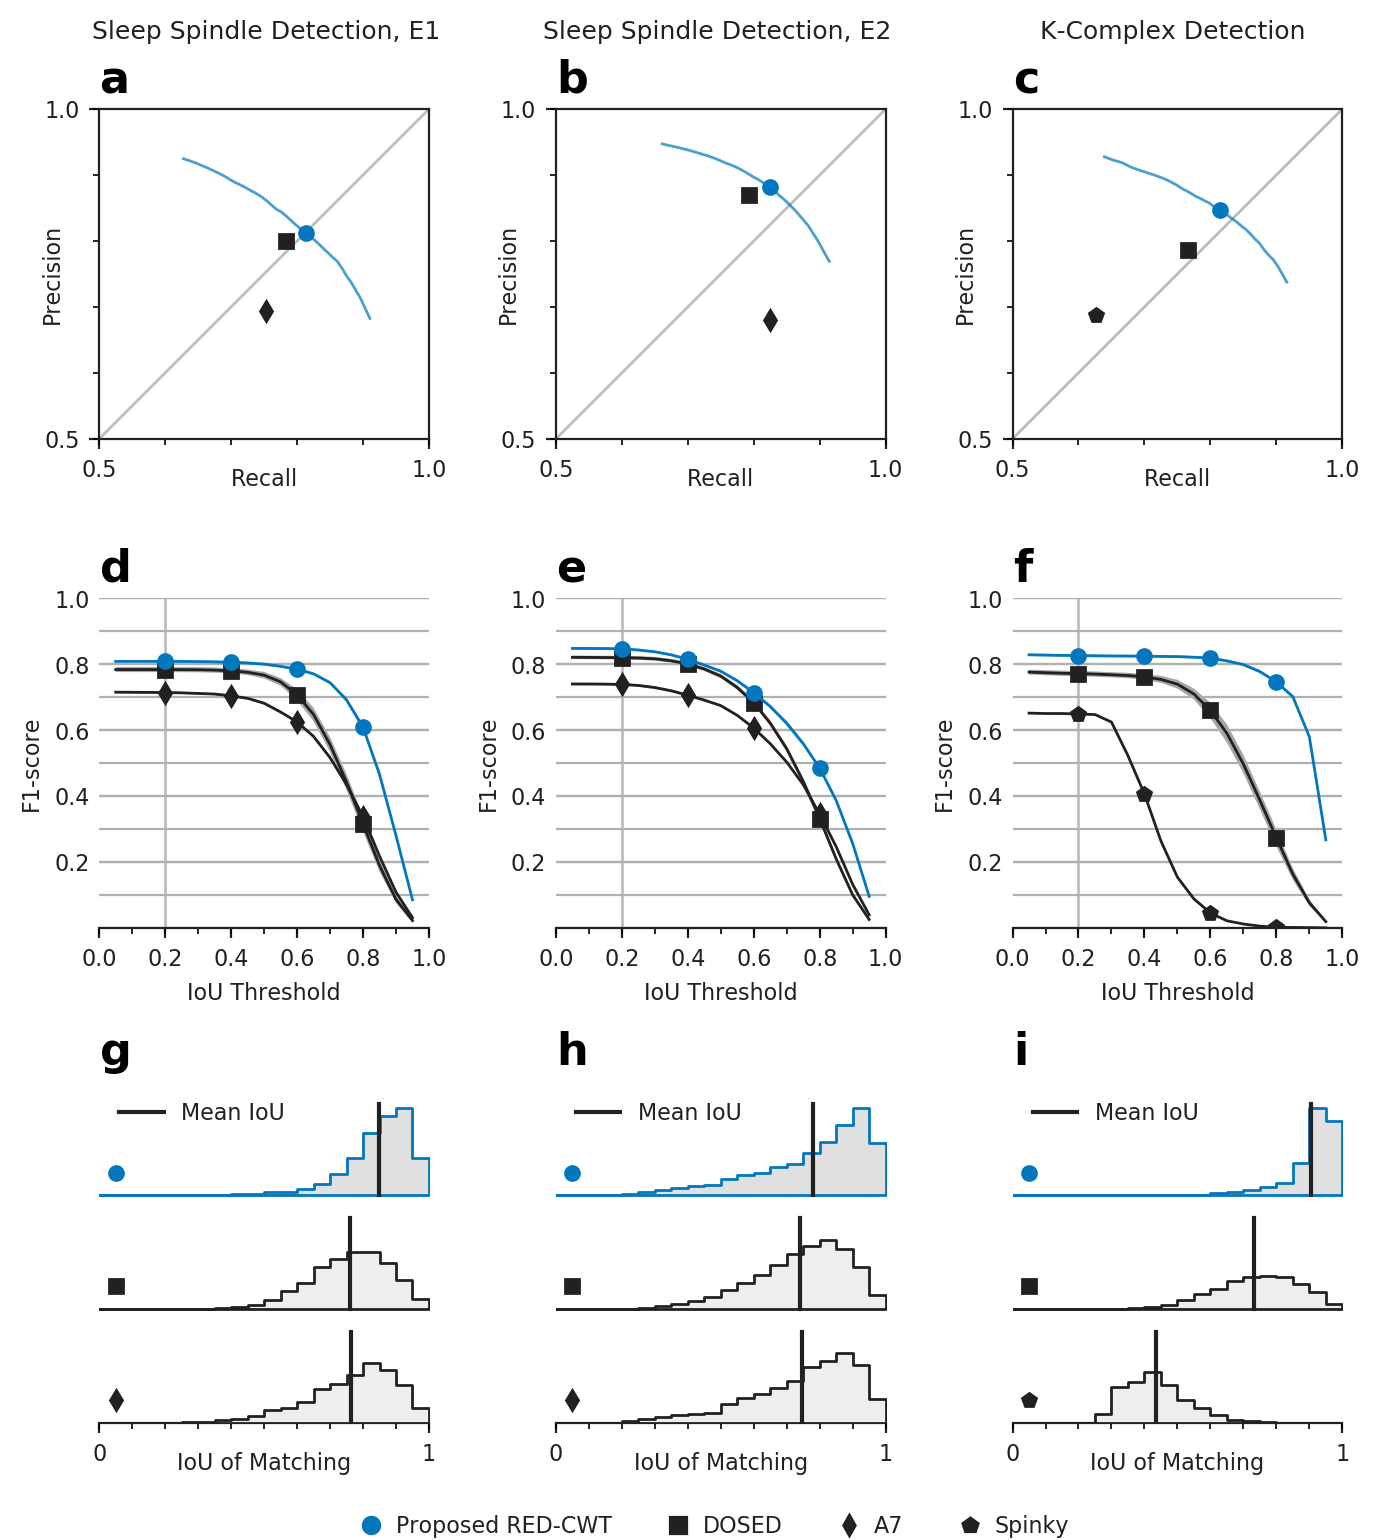

In [13]:
shown_baselines = []
shown_markers = []

def f1_vs_iou_task(ax, task_id, subfig_label=None):
    print('Task %s' % task_id)
    mean_f1_vs_iou = perf_data_dict[task_id][constants.F1_VS_IOU].mean(axis=0)
    std_f1_vs_iou = perf_data_dict[task_id][constants.F1_VS_IOU].std(axis=0)
    idx_markers_iou = [
        misc.closest_index(single_marker, iou_curve_axis) 
        for single_marker in f1_markers_iou]
    ax.plot(
        iou_curve_axis, mean_f1_vs_iou, linewidth=general_lw, zorder=20, marker='o', label=model_label,
        color=custom_color, markersize=viz.MARKERSIZE, markevery=idx_markers_iou)
    if f1_show_seed_std:
        ax.fill_between(
            iou_curve_axis, mean_f1_vs_iou - std_f1_vs_iou, mean_f1_vs_iou + std_f1_vs_iou, 
            alpha=f1_alpha_seed_std, facecolor=custom_color, zorder=20)
    printer.print_performance_at_iou(perf_data_dict[task_id], iou_thr_to_show, model_label)
    for baseline_name in all_baselines_data_dict[task_id].keys():
        bl_data = all_baselines_data_dict[task_id][baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            bl_iou_axis = bl_data[constants.IOU_CURVE_AXIS]
            bl_f1_vs_iou_mean = bl_data[constants.F1_VS_IOU].mean(axis=0)
            bl_f1_vs_iou_std = bl_data[constants.F1_VS_IOU].std(axis=0)
            idx_markers_iou = [
                misc.closest_index(single_marker, bl_iou_axis) 
                for single_marker in f1_markers_iou]
            ax.plot(
                bl_iou_axis, bl_f1_vs_iou_mean, linewidth=general_lw, marker=bl_marker, 
                label=bl_label, color=general_color, markersize=viz.MARKERSIZE, 
                markevery=idx_markers_iou)
            if f1_show_seed_std:
                ax.fill_between(
                    bl_iou_axis, bl_f1_vs_iou_mean - bl_f1_vs_iou_std, bl_f1_vs_iou_mean + bl_f1_vs_iou_std, 
                    alpha=f1_alpha_seed_std, facecolor=general_color)
            printer.print_performance_at_iou(bl_data, iou_thr_to_show, bl_label)
    if subfig_label is not None:
        ax = plotter.add_label_chart(ax, subfig_label, 16)
    ax = plotter.format_metric_vs_iou_plot(ax, 'F1-score', iou_thr_to_show)
    ax = plotter.set_axis_color(ax, general_color)
    ax.set_aspect('equal', 'box')
    return ax

def pr_curve_task(ax, task_id, subfig_label=None):
    ckpt_folder = ckpt_display_dict[task_id][0]
    optimal_thr_list = OPTIMAL_THR_FOR_CKPT_DICT[ckpt_folder]
    op_idx = [misc.closest_index(optimal_thr_list[k], pr_curve_thr) for k in seed_id_list]
    seeds_recall = [pr_curve_data_dict[task_id][k][constants.RECALL] for k in seed_id_list]
    seeds_precision = [pr_curve_data_dict[task_id][k][constants.PRECISION] for k in seed_id_list]
    mean_recall_op = np.mean([seeds_recall[k][op_idx[k]] for k in seed_id_list])
    mean_precision_op = np.mean([seeds_precision[k][op_idx[k]] for k in seed_id_list])
    mean_recall_curve, mean_precision_curve = plotter.average_curves(seeds_recall, seeds_precision)
    ax.plot(
        mean_recall_curve, mean_precision_curve,
        linewidth=general_lw, color=custom_color, zorder=10, alpha=pr_alpha_curve)
    ax.plot(
        mean_recall_op, mean_precision_op, label=model_label,
        linestyle="None", color=custom_color, zorder=20, marker='o', 
        markersize=viz.MARKERSIZE)
    for baseline_name in all_baselines_data_dict[task_id].keys():
        bl_data = all_baselines_data_dict[task_id][baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            if bl_label not in shown_baselines:
                shown_baselines.append(bl_label)
                shown_markers.append(bl_marker)
            bl_iou_axis = bl_data[constants.IOU_CURVE_AXIS]
            bl_recall_vs_iou_mean = bl_data[constants.RECALL_VS_IOU].mean(axis=0)
            bl_precision_vs_iou_mean = bl_data[constants.PRECISION_VS_IOU].mean(axis=0)
            useful_idx = misc.closest_index(iou_thr_to_show, bl_iou_axis)
            bl_recall = bl_recall_vs_iou_mean[useful_idx]
            bl_precision = bl_precision_vs_iou_mean[useful_idx]
            ax.plot(
                bl_recall, bl_precision, 
                markersize=viz.MARKERSIZE, c=general_color, zorder=15, 
                label=bl_label, marker=bl_marker, linestyle="None")
    if subfig_label is not None:
        ax = plotter.add_label_chart(ax, subfig_label, 16)
    ax = plotter.format_precision_recall_plot(
        ax, pr_show_diagonal, pr_show_iso_f1,
        axis_lims=pr_axis_lims,
        pr_major_ticks=pr_major_ticks,
        pr_minor_ticks=pr_minor_ticks)
    ax.set_yticks([0.5, 1.0])
    ax.set_xlabel('Recall', fontsize=viz.FONTSIZE_GENERAL)
    ax.set_ylabel('Precision', fontsize=viz.FONTSIZE_GENERAL)
    ax = plotter.set_axis_color(ax, general_color)
    ax.xaxis.labelpad = -5
    ax.yaxis.labelpad = -7
    ax.set_aspect('equal', 'box')
    return ax

def iou_hist_task(ax, task_id, subfig_label=None):
    model_iou_bins = perf_data_dict[task_id][constants.IOU_HIST_BINS]
    model_iou_hist = perf_data_dict[task_id][constants.IOU_HIST_VALUES].mean(axis=0)
    x, y = plotter.piecewise_constant_histogram(model_iou_bins, model_iou_hist)
    y_sep = 1.3*y.max()
    this_center = 0
    model_mean_iou = perf_data_dict[task_id][constants.MEAN_IOU].mean()
    idx_at_mean = plotter.find_bin_idx(model_mean_iou, model_iou_bins)
    y_at_mean = model_iou_hist[idx_at_mean]
    ax.plot(
        [model_mean_iou, model_mean_iou], [this_center, this_center + 0.8*y_sep],
        linewidth=1.5, color=general_color, zorder=25, label='Mean IoU')
    ax.fill_between(
        x, this_center + y, this_center,
        edgecolor=custom_color, linewidth=general_lw,
        facecolor=viz.GREY_COLORS[3], zorder=20)
    ax.plot(
        0.05, this_center + 0.2*y_sep, 
        markersize=viz.MARKERSIZE, c=custom_color, zorder=15, 
        marker='o', linestyle="None")
    for baseline_name in all_baselines_data_dict[task_id].keys():
        bl_data = all_baselines_data_dict[task_id][baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            bl_iou_bins = bl_data[constants.IOU_HIST_BINS]
            bl_iou_hist = bl_data[constants.IOU_HIST_VALUES].mean(axis=0)
            x, y = plotter.piecewise_constant_histogram(bl_iou_bins, bl_iou_hist)
            this_center = this_center - y_sep
            bl_mean_iou = bl_data[constants.MEAN_IOU].mean()
            idx_at_mean = plotter.find_bin_idx(bl_mean_iou, bl_iou_bins)
            y_at_mean = bl_iou_hist[idx_at_mean]
            ax.plot(
                [bl_mean_iou, bl_mean_iou], [this_center, this_center + 0.8*y_sep],
                linewidth=1.5, color=general_color, zorder=25)
            ax.fill_between(
                x, this_center + y, this_center,
                edgecolor=general_color, linewidth=general_lw,
                facecolor=viz.GREY_COLORS[2], zorder=20)
            ax.plot(
                0.05, this_center + 0.2*y_sep, 
                markersize=viz.MARKERSIZE, c=general_color, zorder=15, 
                marker=bl_marker, linestyle="None")
    if subfig_label is not None:
        ax.set_title(r"$\bf{%s}$" % subfig_label, fontsize=16, loc='left')
    label_txt_list = []
    label_pos_list = []
    ax = plotter.format_iou_hist_plot(
        ax, label_pos_list, label_txt_list,
        iou_major_ticks=iou_major_ticks)
    lg = ax.legend(loc='upper left', fontsize=viz.FONTSIZE_GENERAL, frameon=False)
    lg = plotter.set_legend_color(lg, general_color)
    ax = plotter.set_axis_color(ax, general_color)
    ax.set_ylim([this_center, y_sep])
    ax.xaxis.labelpad = -5
    return ax
    
# F1-score plots
fig, axes = plt.subplots(3, 3, dpi=dpi, figsize=(7, 7.5))
axes[0, 0] = pr_curve_task(axes[0, 0], 'ss_e1', 'a')
axes[0, 1] = pr_curve_task(axes[0, 1], 'ss_e2', 'b')
axes[0, 2] = pr_curve_task(axes[0, 2], 'kc_e1', 'c')
axes[1, 0] = f1_vs_iou_task(axes[1, 0], 'ss_e1', 'd')
axes[1, 1] = f1_vs_iou_task(axes[1, 1], 'ss_e2', 'e')
axes[1, 2] = f1_vs_iou_task(axes[1, 2], 'kc_e1', 'f')
axes[2, 0] = iou_hist_task(axes[2, 0], 'ss_e1', 'g')
axes[2, 1] = iou_hist_task(axes[2, 1], 'ss_e2', 'h')
axes[2, 2] = iou_hist_task(axes[2, 2], 'kc_e1', 'i')

marker_size_legend = 8
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=model_label, markerfacecolor=custom_color, markersize=marker_size_legend)]
for bl_label, bl_marker in zip(shown_baselines, shown_markers):
    legend_elements.append(
        Line2D([0], [0], marker=bl_marker, color='w', label=bl_label, markerfacecolor=general_color, markersize=marker_size_legend)
    )

# axes[0, 0].set_title('Sleep Spindle Detection, E1', fontsize=viz.FONTSIZE_TITLE)
# axes[0, 1].set_title('Sleep Spindle Detection, E2', fontsize=viz.FONTSIZE_TITLE)
# axes[0, 2].set_title('K-Complex Detection', fontsize=viz.FONTSIZE_TITLE)

lg = fig.legend(
    handles=legend_elements,
    loc='upper left', 
    labelspacing=viz.LEGEND_LABEL_SPACING,
    fontsize=viz.FONTSIZE_GENERAL, 
    frameon=False, 
    bbox_to_anchor=(0.235, 0.03), 
    ncol=4,
    handletextpad=0.1
)
lg = plotter.set_legend_color(lg, general_color)

plt.tight_layout()
fig.subplots_adjust(bottom=0.06, top=0.94)

# fig.subplots_adjust(hspace=0.3, top=0.9)

plt.text(
    x=0.073, y=0.983, fontsize=9, 
    s='Sleep Spindle Detection, E1', 
    ha="left", transform=fig.transFigure, color=general_color)
plt.text(
    x=0.395, y=0.983, fontsize=9, 
    s='Sleep Spindle Detection, E2', 
    ha="left", transform=fig.transFigure, color=general_color)
plt.text(
    x=0.75, y=0.983, fontsize=9, 
    s='K-Complex Detection', 
    ha="left", transform=fig.transFigure, color=general_color)

plt.savefig("performance_all.pdf")

plt.show()

In [ ]:
# Only PR curves
fig, axes = plt.subplots(1, 3, dpi=dpi, figsize=(7, 2.8))
axes[0] = pr_curve_task(axes[0], 'ss_e1', 'a')
axes[1] = pr_curve_task(axes[1], 'ss_e2', 'b')
axes[2] = pr_curve_task(axes[2], 'kc_e1', 'c')

marker_size_legend = 8
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Proposed Model', markerfacecolor=custom_color, markersize=marker_size_legend)]
for bl_label, bl_marker in zip(shown_baselines, shown_markers):
    legend_elements.append(
        Line2D([0], [0], marker=bl_marker, color='w', label=bl_label, markerfacecolor=general_color, markersize=marker_size_legend)
    )

# axes[0, 0].set_title('Sleep Spindle Detection, E1', fontsize=viz.FONTSIZE_TITLE)
# axes[0, 1].set_title('Sleep Spindle Detection, E2', fontsize=viz.FONTSIZE_TITLE)
# axes[0, 2].set_title('K-Complex Detection', fontsize=viz.FONTSIZE_TITLE)

lg = fig.legend(
    handles=legend_elements,
    loc='upper left', 
    labelspacing=viz.LEGEND_LABEL_SPACING,
    fontsize=viz.FONTSIZE_GENERAL, 
    frameon=False, 
    bbox_to_anchor=(0.06, 0.1), 
    ncol=4
)
lg = plotter.set_legend_color(lg, general_color)

plt.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.91)

# fig.subplots_adjust(hspace=0.3, top=0.9)

plt.text(
    x=0.073, y=0.91, fontsize=9, 
    s='Sleep Spindle Detection, E1', 
    ha="left", transform=fig.transFigure, color=general_color)
plt.text(
    x=0.395, y=0.91, fontsize=9, 
    s='Sleep Spindle Detection, E2', 
    ha="left", transform=fig.transFigure, color=general_color)
plt.text(
    x=0.75, y=0.91, fontsize=9, 
    s='K-Complex Detection', 
    ha="left", transform=fig.transFigure, color=general_color)

# plt.savefig("pr_curves.svg")

plt.show()


In [ ]:
# IoU hist plots
# F1-score plots
fig, axes = plt.subplots(2, 3, dpi=dpi, figsize=(7, 5.2))
axes[0, 0] = f1_vs_iou_task(axes[0, 0], 'ss_e1', 'a')
axes[0, 1] = f1_vs_iou_task(axes[0, 1], 'ss_e2', 'b')
axes[0, 2] = f1_vs_iou_task(axes[0, 2], 'kc_e1', 'c')
axes[1, 0] = iou_hist_task(axes[1, 0], 'ss_e1', 'd')
axes[1, 1] = iou_hist_task(axes[1, 1], 'ss_e2', 'e')
axes[1, 2] = iou_hist_task(axes[1, 2], 'kc_e1', 'f')

marker_size_legend = 8
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Proposed Model', markerfacecolor=custom_color, markersize=marker_size_legend)]
for bl_label, bl_marker in zip(shown_baselines, shown_markers):
    legend_elements.append(
        Line2D([0], [0], marker=bl_marker, color='w', label=bl_label, markerfacecolor=general_color, markersize=marker_size_legend)
    )

# axes[0, 0].set_title('Sleep Spindle Detection, E1', fontsize=viz.FONTSIZE_TITLE)
# axes[0, 1].set_title('Sleep Spindle Detection, E2', fontsize=viz.FONTSIZE_TITLE)
# axes[0, 2].set_title('K-Complex Detection', fontsize=viz.FONTSIZE_TITLE)

lg = fig.legend(
    handles=legend_elements,
    loc='upper left', 
    labelspacing=viz.LEGEND_LABEL_SPACING,
    fontsize=viz.FONTSIZE_GENERAL, 
    frameon=False, 
    bbox_to_anchor=(0.06, 0.06), 
    ncol=4
)
lg = plotter.set_legend_color(lg, general_color)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12, top=0.91)

# fig.subplots_adjust(hspace=0.3, top=0.9)

plt.text(
    x=0.073, y=0.96, fontsize=9, 
    s='Sleep Spindle Detection, E1', 
    ha="left", transform=fig.transFigure, color=general_color)
plt.text(
    x=0.395, y=0.96, fontsize=9, 
    s='Sleep Spindle Detection, E2', 
    ha="left", transform=fig.transFigure, color=general_color)
plt.text(
    x=0.75, y=0.96, fontsize=9, 
    s='K-Complex Detection', 
    ha="left", transform=fig.transFigure, color=general_color)

# plt.savefig("f1_iou.svg")

plt.show()